<a href="https://colab.research.google.com/github/Foysal348/Single-Server-Queueing-System/blob/main/Assignment_of_Single_Server_Queueing_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The single server queueing system requirements are
1. IID random variable
2. Average waiting time
3. Average queue length
4. Interarrival time
5. Service time for customers

# Import Essential Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# ROBUST SINGLE SERVER QUEUE SIMULATION (M/M/1)


class SingleServerQueue:
    """
    Discrete-event simulation of M/M/1 queue (robust implementation)
    """
    def __init__(self, arrival_rate, service_rate, simulation_time, seed=None):
        self.arrival_rate = float(arrival_rate)
        self.service_rate = float(service_rate)
        self.simulation_time = float(simulation_time)
        self.utilization = self.arrival_rate / self.service_rate if self.service_rate > 0 else np.nan

        # State
        self.clock = 0.0
        self.num_in_system = 0
        self.server_busy = False
        self.current_serving_idx = None  # index into self.customers

        # Event times
        self.next_arrival = None
        self.next_departure = float('inf')

        # Stats (time-weighted)
        self.last_event_time = 0.0
        self.area_under_s = 0.0
        self.area_under_q = 0.0
        self.busy_time = 0.0

        # Counters
        self.num_arrivals = 0
        self.num_departed = 0
        self.total_wait_time = 0.0
        self.total_system_time = 0.0

        # Structures
        self.queue = deque()
        self.customers = []  # list of dicts for each customer
        self.system_state_history = []

        if seed is not None:
            np.random.seed(seed)

    def generate_interarrival(self):
        return np.random.exponential(1.0 / self.arrival_rate)

    def generate_service(self):
        return np.random.exponential(1.0 / self.service_rate)

    def update_time_based_stats(self):
        dt = self.clock - self.last_event_time
        if dt > 0:
            self.area_under_s += self.num_in_system * dt
            queue_len = max(0, self.num_in_system - (1 if self.server_busy else 0))
            self.area_under_q += queue_len * dt
            self.busy_time += (1.0 if self.server_busy else 0.0) * dt
            self.last_event_time = self.clock

    def schedule_first_arrival(self):
        # called at start to set next_arrival
        self.next_arrival = self.clock + self.generate_interarrival()

    def process_arrival(self):
        # arrival happens at self.clock
        self.update_time_based_stats()

        self.num_arrivals += 1
        cust_idx = len(self.customers)
        customer = {
            'id': self.num_arrivals,
            'arrival_time': self.clock,
            'service_start_time': None,
            'departure_time': None,
            'service_time': None,
            'wait_time': None,
            'system_time': None
        }
        self.customers.append(customer)

        # if server idle -> start service immediately
        if not self.server_busy:
            self.server_busy = True
            self.current_serving_idx = cust_idx
            customer['service_start_time'] = self.clock
            st = self.generate_service()
            customer['service_time'] = st
            customer['departure_time'] = self.clock + st
            self.next_departure = customer['departure_time']
        else:
            # join queue
            self.queue.append(cust_idx)

        # update counts & history (after change)
        self.num_in_system += 1
        self.system_state_history.append({
            'time': self.clock,
            'num_in_system': self.num_in_system,
            'num_in_queue': max(0, self.num_in_system - (1 if self.server_busy else 0)),
            'server_busy': int(self.server_busy),
            'event': 'arrival'
        })

        # schedule next arrival (could be beyond sim horizon)
        self.next_arrival = self.clock + self.generate_interarrival()

    def process_departure(self):
        # departure happens at self.clock
        self.update_time_based_stats()

        # finalize departing customer (must exist)
        if self.current_serving_idx is not None:
            cust = self.customers[self.current_serving_idx]
            cust['departure_time'] = self.clock
            cust['system_time'] = cust['departure_time'] - cust['arrival_time']
            cust['wait_time'] = (cust['service_start_time'] - cust['arrival_time']) if cust['service_start_time'] is not None else 0.0
            self.total_wait_time += cust['wait_time']
            self.total_system_time += cust['system_time']
            self.num_departed += 1
        else:
            # safety fallback
            pass

        # reduce count
        self.num_in_system -= 1

        # serve next in queue if any
        if self.queue:
            next_idx = self.queue.popleft()
            self.current_serving_idx = next_idx
            self.server_busy = True
            cust2 = self.customers[next_idx]
            cust2['service_start_time'] = self.clock
            st = self.generate_service()
            cust2['service_time'] = st
            cust2['departure_time'] = self.clock + st
            self.next_departure = cust2['departure_time']
        else:
            # server goes idle
            self.server_busy = False
            self.current_serving_idx = None
            self.next_departure = float('inf')

        # record history AFTER changes
        self.system_state_history.append({
            'time': self.clock,
            'num_in_system': self.num_in_system,
            'num_in_queue': max(0, self.num_in_system - (1 if self.server_busy else 0)),
            'server_busy': int(self.server_busy),
            'event': 'departure'
        })

    def run_simulation(self):
        # init first arrival
        self.schedule_first_arrival()
        self.next_departure = float('inf')
        self.last_event_time = 0.0
        self.clock = 0.0

        while self.clock < self.simulation_time:
            # pick next event
            if self.next_arrival <= self.next_departure:
                # advance to arrival (if arrival beyond sim horizon, break)
                if self.next_arrival > self.simulation_time:
                    self.clock = self.simulation_time
                    break
                self.clock = self.next_arrival
                self.process_arrival()
            else:
                # next event is departure
                if self.next_departure > self.simulation_time:
                    self.clock = self.simulation_time
                    break
                self.clock = self.next_departure
                self.process_departure()

        # final time update
        self.update_time_based_stats()

        return self.calculate_statistics()

    def calculate_statistics(self):
        clock = max(self.clock, 1e-12)
        avg_num_in_system = self.area_under_s / clock
        avg_num_in_queue = self.area_under_q / clock
        avg_wait_time = (self.total_wait_time / self.num_departed) if self.num_departed > 0 else 0.0
        avg_system_time = (self.total_system_time / self.num_departed) if self.num_departed > 0 else 0.0
        server_utilization = self.busy_time / clock

        return {
            'average_customers_in_system': avg_num_in_system,
            'average_customers_in_queue': avg_num_in_queue,
            'average_wait_time': avg_wait_time,
            'average_system_time': avg_system_time,
            'server_utilization': server_utilization,
            'total_arrivals': self.num_arrivals,
            'total_departures': self.num_departed,
            'simulation_time': self.clock,
            'theoretical_utilization': self.utilization
        }

# ============================================
# VISUALIZATION FUNCTIONS (Matplotlib Only)
# ============================================





# VISUALIZATION FUNCTIONS (Matplotlib Only)

SINGLE SERVER QUEUEING SYSTEM SIMULATION

Simulation Parameters:
  Arrival rate (λ): 4.0 customers/time unit
  Service rate (μ): 5.0 customers/time unit
  Utilization (ρ = λ/μ): 0.800
  Simulation time: 100 time units

SIMULATION RESULTS:
--------------------------------------------------
Average customers in system: 3.695
Average customers in queue: 2.851
Average wait time: 0.695
Average system time: 0.901
Server utilization: 0.844
Total arrivals: 410
Total departures: 410
Simulation time: 100.00

THEORETICAL VALUES (M/M/1):
--------------------------------------------------
Avg in system (L): 4.000
Avg in queue (Lq): 3.200
Avg wait time (Wq): 0.800
Avg system time (W): 1.000
Server utilization: 0.800

PERCENTAGE DIFFERENCE (Theoretical vs Actual):
--------------------------------------------------
System size: 7.6%
Queue length: 10.9%

PERFORMANCE ANALYSIS:
--------------------------------------------------
   Queue lengths and wait times may be excessive

Generating Visualizations..

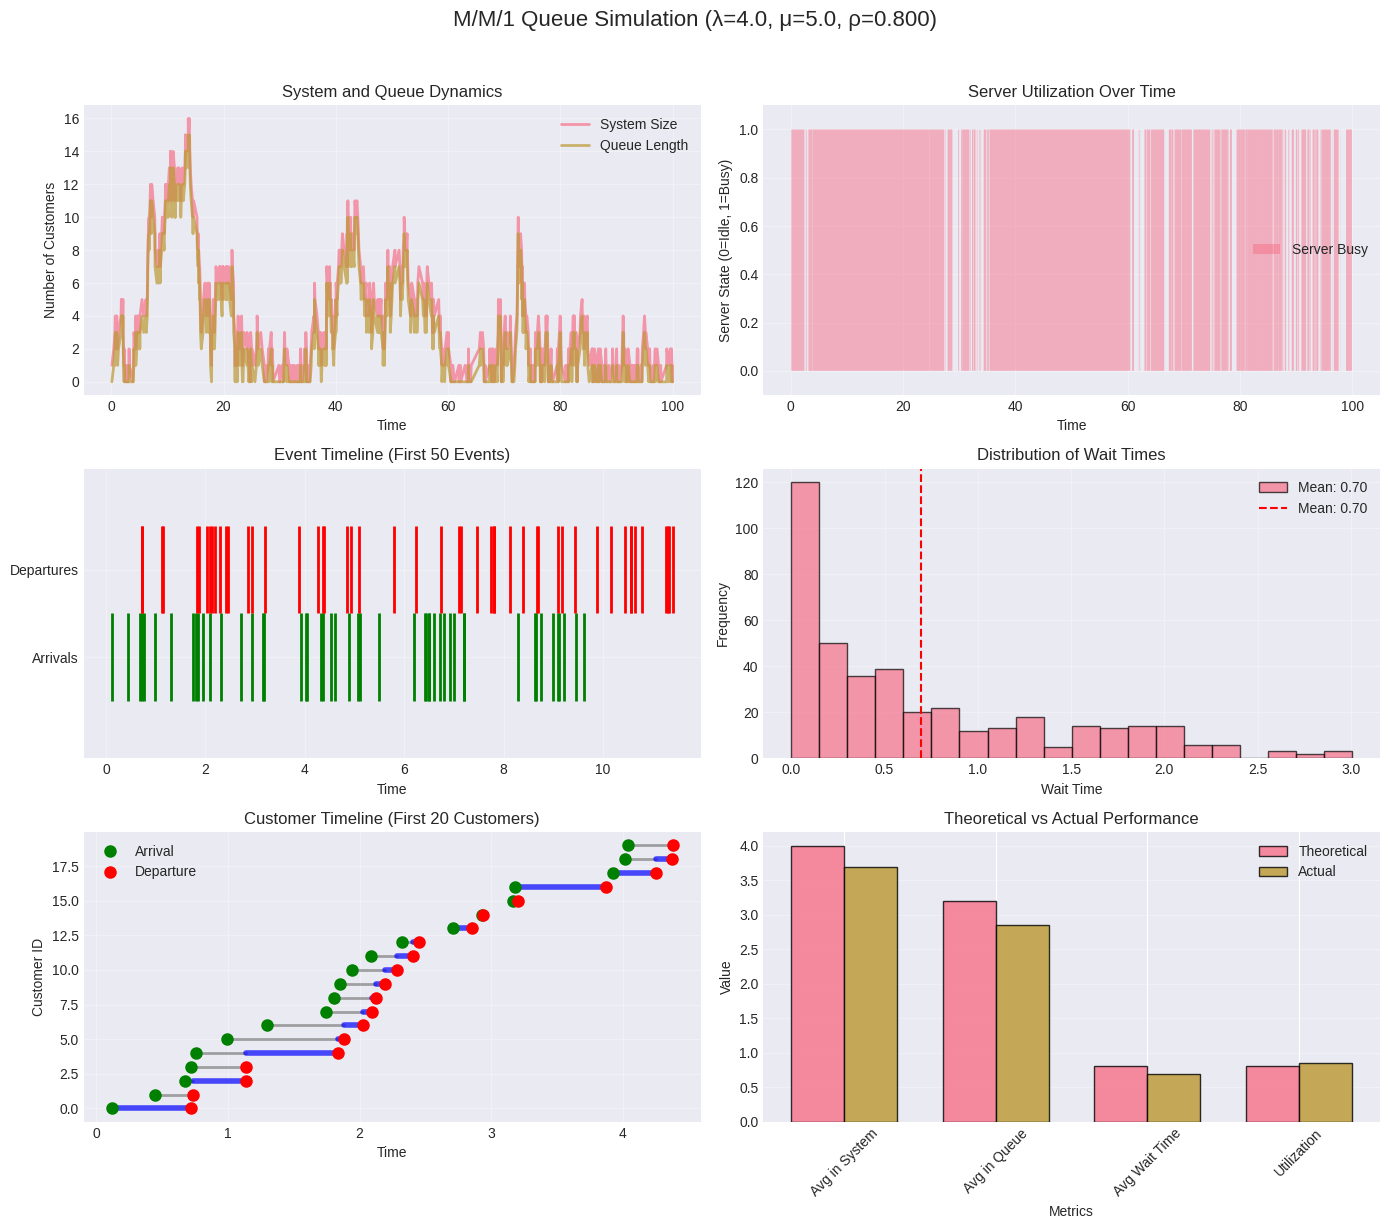


SENSITIVITY ANALYSIS


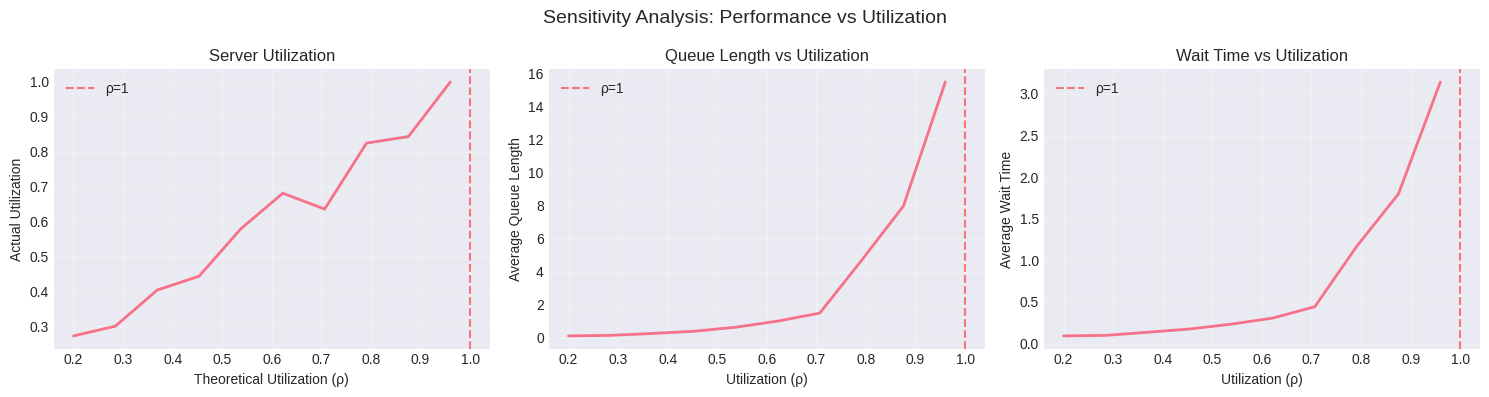


SUMMARY STATISTICS

Little's Law Validation:
  L (avg in system) = 3.695
  λ (actual arrival rate) = 4.100
  W (avg system time) = 0.901
  λ × W = 3.695
  Difference: 0.000 (0.0%)

SIMULATION COMPLETE!


In [ ]:
def plot_system_dynamics(queue_sim):
    """Comprehensive visualization using matplotlib (keeps your original layout)
    Returns: matplotlib.figure.Figure
    """
    history_df = pd.DataFrame(queue_sim.system_state_history)

    # Create figure with subplots
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))

    # 1. System Size Over Time
    if len(history_df) > 0:
        axes[0, 0].plot(history_df['time'], history_df['num_in_system'],
                        label='System Size', alpha=0.7, linewidth=2)
        axes[0, 0].plot(history_df['time'], history_df['num_in_queue'],
                        label='Queue Length', alpha=0.7, linewidth=2)
        axes[0, 0].set_xlabel('Time')
        axes[0, 0].set_ylabel('Number of Customers')
        axes[0, 0].set_title('System and Queue Dynamics')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

    # 2. Server State (as filled step)
    if len(history_df) > 0:
        # Build a step-like busy timeline for nicer display
        times = history_df['time'].values
        busy = history_df['server_busy'].astype(int).values
        # To make step, repeat each point
        if len(times) > 1:
            t_step = np.repeat(times, 2)[1:]
            b_step = np.repeat(busy, 2)[:-1]
            axes[0, 1].fill_between(t_step, 0, b_step, alpha=0.5, label='Server Busy')
        else:
            axes[0, 1].fill_between([0, queue_sim.simulation_time], [0,0], [busy[0], busy[0]], alpha=0.5)

        axes[0, 1].set_xlabel('Time')
        axes[0, 1].set_ylabel('Server State (0=Idle, 1=Busy)')
        axes[0, 1].set_title('Server Utilization Over Time')
        axes[0, 1].set_ylim(-0.1, 1.1)
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

    # 3. Event Timeline (First 50 events)
    if queue_sim.arrival_times if hasattr(queue_sim, 'arrival_times') else True:
        # We can reconstruct arrival/departure samples from customers
        arrivals = [c['arrival_time'] for c in queue_sim.customers][:50]
        departures = [c['departure_time'] for c in queue_sim.customers if c['departure_time'] is not None][:50]

        if len(arrivals) > 0:
            axes[1, 0].eventplot([arrivals, departures],
                                colors=['green', 'red'], lineoffsets=[1, 2], linewidths=[2, 2])
            axes[1, 0].set_xlabel('Time')
            axes[1, 0].set_yticks([1, 2])
            axes[1, 0].set_yticklabels(['Arrivals', 'Departures'])
            axes[1, 0].set_title('Event Timeline (First 50 Events)')
            axes[1, 0].grid(True, alpha=0.3)

    # 4. Histogram of Wait Times
    if queue_sim.customers:
        customers_df = pd.DataFrame(queue_sim.customers)
        if 'wait_time' in customers_df.columns:
            wait_times = customers_df['wait_time'].dropna()
            if len(wait_times) > 0:
                axes[1, 1].hist(wait_times, bins=20, alpha=0.7,
                               label=f'Mean: {wait_times.mean():.2f}',
                               edgecolor='black')
                axes[1, 1].axvline(wait_times.mean(), color='red',
                                  linestyle='--', label=f'Mean: {wait_times.mean():.2f}')
                axes[1, 1].set_xlabel('Wait Time')
                axes[1, 1].set_ylabel('Frequency')
                axes[1, 1].set_title('Distribution of Wait Times')
                axes[1, 1].legend()
                axes[1, 1].grid(True, alpha=0.3)

    # 5. Customer Flow (First 20 customers)
    if queue_sim.customers:
        customers_df = pd.DataFrame(queue_sim.customers).head(20)
        for idx, customer in customers_df.iterrows():
            if pd.notnull(customer.get('arrival_time')) and pd.notnull(customer.get('departure_time')):
                # Wait period
                axes[2, 0].plot([customer['arrival_time'], customer.get('service_start_time', customer['arrival_time'])],
                              [idx, idx], 'gray', linewidth=2, alpha=0.7)
                # Service period
                if pd.notnull(customer.get('service_start_time')):
                    axes[2, 0].plot([customer['service_start_time'], customer['departure_time']],
                                  [idx, idx], 'blue', linewidth=4, alpha=0.7)
                # Mark arrival and departure
                axes[2, 0].plot(customer['arrival_time'], idx, 'go', markersize=8, label='Arrival' if idx == 0 else "")
                axes[2, 0].plot(customer['departure_time'], idx, 'ro', markersize=8, label='Departure' if idx == 0 else "")

        axes[2, 0].set_xlabel('Time')
        axes[2, 0].set_ylabel('Customer ID')
        axes[2, 0].set_title('Customer Timeline (First 20 Customers)')
        axes[2, 0].legend()
        axes[2, 0].grid(True, alpha=0.3)

    # 6. Theoretical vs Actual Comparison
    stats = queue_sim.calculate_statistics()
    λ = queue_sim.arrival_rate
    μ = queue_sim.service_rate
    ρ = λ / μ

    metrics = ['Avg in System', 'Avg in Queue', 'Avg Wait Time', 'Utilization']

    # Theoretical values (M/M/1)
    if ρ < 1:
        theoretical = [
            ρ/(1-ρ),
            ρ**2/(1-ρ),
            ρ/(μ-λ),
            ρ
        ]
    else:
        theoretical = [np.nan, np.nan, np.nan, ρ]

    actual = [
        stats['average_customers_in_system'],
        stats['average_customers_in_queue'],
        stats['average_wait_time'],
        stats['server_utilization']
    ]

    x = np.arange(len(metrics))
    width = 0.35

    axes[2, 1].bar(x - width/2, theoretical, width, label='Theoretical',
                  edgecolor='black', alpha=0.8)
    axes[2, 1].bar(x + width/2, actual, width, label='Actual',
                  edgecolor='black', alpha=0.8)
    axes[2, 1].set_xlabel('Metrics')
    axes[2, 1].set_ylabel('Value')
    axes[2, 1].set_title('Theoretical vs Actual Performance')
    axes[2, 1].set_xticks(x)
    axes[2, 1].set_xticklabels(metrics, rotation=45)
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3, axis='y')

    plt.suptitle(f'M/M/1 Queue Simulation (λ={λ}, μ={μ}, ρ={ρ:.3f})', fontsize=16, y=1.02)
    plt.tight_layout()
    return fig


def run_sensitivity_analysis():
    """Analyze system performance across different utilizations (keeps your plotting)
    Returns DataFrame of results
    """
    print("\n" + "="*60)
    print("SENSITIVITY ANALYSIS")
    print("="*60)

    base_service = 5.0
    sim_time = 100

    # Test different arrival rates
    arrival_rates = np.linspace(1.0, 4.8, 10)

    results = []
    for arr_rate in arrival_rates:
        queue = SingleServerQueue(arr_rate, base_service, sim_time, seed=1)
        stats = queue.run_simulation()

        results.append({
            'arrival_rate': arr_rate,
            'utilization': arr_rate / base_service,
            'avg_queue': stats['average_customers_in_queue'],
            'avg_wait': stats['average_wait_time'],
            'server_util': stats['server_utilization']
        })

    results_df = pd.DataFrame(results)

    # Plot sensitivity analysis
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(results_df['utilization'], results_df['server_util'], linewidth=2)
    axes[0].set_xlabel('Theoretical Utilization (ρ)')
    axes[0].set_ylabel('Actual Utilization')
    axes[0].set_title('Server Utilization')
    axes[0].grid(True, alpha=0.3)
    axes[0].axvline(x=1, color='red', linestyle='--', alpha=0.5, label='ρ=1')
    axes[0].legend()

    axes[1].plot(results_df['utilization'], results_df['avg_queue'], linewidth=2)
    axes[1].set_xlabel('Utilization (ρ)')
    axes[1].set_ylabel('Average Queue Length')
    axes[1].set_title('Queue Length vs Utilization')
    axes[1].grid(True, alpha=0.3)
    axes[1].axvline(x=1, color='red', linestyle='--', alpha=0.5, label='ρ=1')
    axes[1].legend()

    axes[2].plot(results_df['utilization'], results_df['avg_wait'], linewidth=2)
    axes[2].set_xlabel('Utilization (ρ)')
    axes[2].set_ylabel('Average Wait Time')
    axes[2].set_title('Wait Time vs Utilization')
    axes[2].grid(True, alpha=0.3)
    axes[2].axvline(x=1, color='red', linestyle='--', alpha=0.5, label='ρ=1')
    axes[2].legend()

    plt.suptitle('Sensitivity Analysis: Performance vs Utilization', fontsize=14)
    plt.tight_layout()

    return results_df


# MAIN EXECUTION (Integrates your original CLI & visual flow)


def main():
    print("="*70)
    print("SINGLE SERVER QUEUEING SYSTEM SIMULATION")
    print("="*70)

    # Simulation parameters
    arrival_rate = 4.0    # λ: Average 4 customers per time unit
    service_rate = 5.0    # μ: Average 5 customers per time unit
    simulation_time = 100  # Total simulation time

    print(f"\nSimulation Parameters:")
    print(f"  Arrival rate (λ): {arrival_rate} customers/time unit")
    print(f"  Service rate (μ): {service_rate} customers/time unit")
    print(f"  Utilization (ρ = λ/μ): {arrival_rate/service_rate:.3f}")
    print(f"  Simulation time: {simulation_time} time units")

    queue_sim = SingleServerQueue(arrival_rate, service_rate, simulation_time, seed=42)
    statistics = queue_sim.run_simulation()

    # Print results
    print("\nSIMULATION RESULTS:")
    print("-"*50)
    print(f"Average customers in system: {statistics['average_customers_in_system']:.3f}")
    print(f"Average customers in queue: {statistics['average_customers_in_queue']:.3f}")
    print(f"Average wait time: {statistics['average_wait_time']:.3f}")
    print(f"Average system time: {statistics['average_system_time']:.3f}")
    print(f"Server utilization: {statistics['server_utilization']:.3f}")
    print(f"Total arrivals: {statistics['total_arrivals']}")
    print(f"Total departures: {statistics['total_departures']}")
    print(f"Simulation time: {statistics['simulation_time']:.2f}")

    # Theoretical calculations
    ρ = arrival_rate / service_rate
    if ρ < 1:
        print("\nTHEORETICAL VALUES (M/M/1):")
        print("-"*50)
        print(f"Avg in system (L): {ρ/(1-ρ):.3f}")
        print(f"Avg in queue (Lq): {(ρ**2)/(1-ρ):.3f}")
        print(f"Avg wait time (Wq): {ρ/(service_rate-arrival_rate):.3f}")
        print(f"Avg system time (W): {1/(service_rate-arrival_rate):.3f}")
        print(f"Server utilization: {ρ:.3f}")

        # Calculate percentage difference
        print("\nPERCENTAGE DIFFERENCE (Theoretical vs Actual):")
        print("-"*50)
        print(f"System size: {abs(ρ/(1-ρ) - statistics['average_customers_in_system'])/ (ρ/(1-ρ)) * 100:.1f}%")
        print(f"Queue length: {abs((ρ**2)/(1-ρ) - statistics['average_customers_in_queue'])/ ((ρ**2)/(1-ρ)) * 100:.1f}%")
    else:
        print("\nTHEORETICAL: System is unstable (ρ ≥ 1)")

    # Performance analysis
    print("\nPERFORMANCE ANALYSIS:")
    print("-"*50)
    if ρ >= 1:
        print(" WARNING: System is unstable (ρ ≥ 1)")
        print("   Queue will grow indefinitely over time")
    elif ρ >= 0.8:
        print("  WARNING: High utilization (ρ ≥ 0.8)")
        print("   Queue lengths and wait times may be excessive")
    else:
        print("✓ System is operating in stable region")

    if statistics['average_customers_in_queue'] > 3:
        print(f"  Potential bottleneck: Long queue detected")
        print(f"   Average queue length: {statistics['average_customers_in_queue']:.2f}")

    # Generate visualizations
    print("\n" + "="*70)
    print("Generating Visualizations...")
    print("="*70)
    fig = plot_system_dynamics(queue_sim)
    plt.show()

    # Run sensitivity analysis
    results_df = run_sensitivity_analysis()
    plt.show()

    # Print summary statistics
    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)

    # Calculate Little's Law validation
    L = statistics['average_customers_in_system']
    λ_actual = statistics['total_arrivals'] / statistics['simulation_time']
    W = statistics['average_system_time']

    print(f"\nLittle's Law Validation:")
    print(f"  L (avg in system) = {L:.3f}")
    print(f"  λ (actual arrival rate) = {λ_actual:.3f}")
    print(f"  W (avg system time) = {W:.3f}")
    print(f"  λ × W = {λ_actual * W:.3f}")
    print(f"  Difference: {abs(L - λ_actual * W):.3f} ({abs((L - λ_actual * W)/L)*100:.1f}%)")

    return queue_sim, statistics

# Run the simulation
if __name__ == "__main__":
    queue_sim, stats = main()

    print("\n" + "="*70)
    print("SIMULATION COMPLETE!")
    print("="*70)

